# Table of Content:
1. EDA - Original Dataset - 2017 onward <br>
    1.1 Data Acquisition and Exploration <br>
    1.2 Univariate Plots <br>
    1.3 Checking for Homoscedasticity <br>
    1.4 Statsmodels <br>
2. Data Cleaning and Wrangling - 2017 onward <br>
    2.1 Data Cleaning <br>
    2.2 Feature Engineering <br>
    2.3 Checking for Homoscedasticity <br>
    2.4 HDB Geospatial <br>
3. EDA and Feature Selection - 2017 onward <br>
    3.1 Scatter Plots of Numerical Features <br>
    3.2 Histograms of Numerical Features <br>
    3.3 Histograms and Boxplots of Categorical Features <br>
    3.4 Encoding <br>
    3.5 Correlation Heatmap of Resale Price with All Features <br>
    3.6 Pairwise Correlation <br>
    3.7 Low Variance <br>
    3.8 Recursive Feature Elimination Cross Validation <br>
    3.9 CART and Boosted Feature Importance <br>
    3.10 Permutation Feature Importance <br>
    3.11 Final Feature Selection <br>
4. Model Selection and Tuning - 2017 onward <br>
    4.1 [Model Preparation](#Model-Preparation) <br>
    4.2 [Conclusion](#Conclusion) <br>
    4.3 [Benefits of the model](#Benefits-of-the-model) <br>
    4.4 [Limitations of the model](#Limitations-of-the-model) <br>
    4.5 [Future Work](#Future-Work) <br>
    4.6 [Model Improvement](#Model-Improvement) <br>
    4.7 [Web Application Improvement](#Web-Application-Improvement) <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.svm import SVR
from xgboost import XGBRegressor
import lightgbm as lgb

from imblearn.over_sampling import SMOTE

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline

In [2]:
hdb = pd.read_csv('dataset/hdb_17_final_features.csv')

## Model Preparation
### Train Test Split & Standard Scaler

The typical work flow for building a model based on supervised learning from a training set involves splitting datasets into random train and test subsets. I will train the model on the train subsets and then test it on the test subsets.

In [3]:
X = hdb.drop(columns=['resale_price'])
y = hdb['resale_price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Instiantiate models
models = {'lr': LinearRegression(),
          'rd': Ridge(random_state=42),
          'ls': Lasso(random_state=42),
          'dt': DecisionTreeRegressor(random_state=42),
          'et': ExtraTreesRegressor(random_state=42),
          'rf': RandomForestRegressor(random_state=42),
          'gb': GradientBoostingRegressor(random_state=42),
          'ab': AdaBoostRegressor(random_state=42),
          'svr': SVR(),
          'xgb': XGBRegressor(random_state=42),
          'lg': lgb.LGBMRegressor(random_state=42),
          'knr': KNeighborsRegressor()
         }

In [6]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=5, verbose=1, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    results['model'] = mod
    results['train R2'] = round(pipe.score(X_train, y_train), 4)
    results['test R2'] = round(pipe.score(X_test, y_test), 4)
    results['CV R2'] = round((cross_val_score(pipe, X_train, y_train, cv=5)).mean(), 4)
    results['train adj_R2'] = round((1 - (1 - pipe.score(X_train, y_train)) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))), 4)
    results['test adj_R2'] = round((1 - (1 - pipe.score(X_test, y_test)) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))), 4)
    results['CV adj_R2'] = round((1 - (1 - (cross_val_score(pipe, X_train, y_train, cv=5)).mean()) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))), 4)
    results['train RMSE'] = round(np.sqrt(mean_squared_error(y_train, pipe.predict(X_train))), 2)
    results['test RMSE'] = round(np.sqrt(mean_squared_error(y_test, pipe.predict(X_test))), 2)
    results['CV RMSE'] = round(-cross_val_score(pipe, X_train, y_train, cv=5, 
                                          scoring='neg_root_mean_squared_error').mean(), 2)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    return pipe

#### Linear Regression

[Linear Regression](https://towardsdatascience.com/assumptions-of-linear-regression-algorithm-ed9ea32224e1) is the standard algorithm for regression that assumes a linear relationship between inputs and the target variable.

[Multiple Linear Regression](https://www.investopedia.com/terms/m/mlr.asp) is like Linear Regression, but with more than one independent variables, which mean we are using multiple independent variables to predict the target variable.

I will be using Linear Regression as my baseline model that will provide us an useful first step, and allow us to understand our problem better in order to inform us on th best way to approach it.

In [7]:
Pipeline([('lr', LinearRegression())]).get_params()

{'memory': None,
 'steps': [('lr', LinearRegression())],
 'verbose': False,
 'lr': LinearRegression(),
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__normalize': False}

In [8]:
lr_params = {
    'lr__n_jobs': [None, -1]
            }

In [9]:
lr_gs = run_model('lr', mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()), ('lr', LinearRegression())])

### METRICS ###


{'model': 'lr',
 'train R2': 0.8922,
 'test R2': 0.8903,
 'CV R2': 0.8919,
 'train adj_R2': 0.8921,
 'test adj_R2': 0.8901,
 'CV adj_R2': 0.8918,
 'train RMSE': 50676.87,
 'test RMSE': 50569.51,
 'CV RMSE': 50733.88}

#### Ridge Regression

[Ridge regression](https://machinelearningmastery.com/ridge-regression-with-python/) is a regularized linear regression that includes an L2 penalty. It has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task.

In [10]:
Pipeline([('rd', Ridge())]).get_params()

{'memory': None,
 'steps': [('rd', Ridge())],
 'verbose': False,
 'rd': Ridge(),
 'rd__alpha': 1.0,
 'rd__copy_X': True,
 'rd__fit_intercept': True,
 'rd__max_iter': None,
 'rd__normalize': False,
 'rd__random_state': None,
 'rd__solver': 'auto',
 'rd__tol': 0.001}

In [11]:
rd_params = {
    'rd__alpha': np.linspace(1, 2, 5)
            }

In [12]:
rd_gs = run_model('rd', mod_params=rd_params, grid_search=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('rd', Ridge(alpha=1.25, random_state=42))])

### METRICS ###


{'model': 'rd',
 'train R2': 0.8922,
 'test R2': 0.8903,
 'CV R2': 0.8919,
 'train adj_R2': 0.8921,
 'test adj_R2': 0.8901,
 'CV adj_R2': 0.8918,
 'train RMSE': 50676.89,
 'test RMSE': 50569.41,
 'CV RMSE': 50733.86}

#### Lasso Regression

[Lasso Regression](https://machinelearningmastery.com/lasso-regression-with-python/) is a regularized linear regression that includes an L1 penalty. It has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task. This penalty allows some coefficient values of the input variable become zero, allowing input variables to be effectively removed from the model, providing a type of automatic feature selection.

In [13]:
Pipeline([('ls', Lasso())]).get_params()

{'memory': None,
 'steps': [('ls', Lasso())],
 'verbose': False,
 'ls': Lasso(),
 'ls__alpha': 1.0,
 'ls__copy_X': True,
 'ls__fit_intercept': True,
 'ls__max_iter': 1000,
 'ls__normalize': False,
 'ls__positive': False,
 'ls__precompute': False,
 'ls__random_state': None,
 'ls__selection': 'cyclic',
 'ls__tol': 0.0001,
 'ls__warm_start': False}

In [14]:
ls_params = {
    'ls__alpha': np.linspace(95, 97, 5),
    'ls__max_iter': [500, 1000]
            }

In [15]:
ls_gs = run_model('ls', mod_params=ls_params, grid_search=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('ls', Lasso(alpha=95.0, max_iter=500, random_state=42))])

### METRICS ###


{'model': 'ls',
 'train R2': 0.8918,
 'test R2': 0.8899,
 'CV R2': 0.8915,
 'train adj_R2': 0.8917,
 'test adj_R2': 0.8897,
 'CV adj_R2': 0.8914,
 'train RMSE': 50761.81,
 'test RMSE': 50648.79,
 'CV RMSE': 50815.99}

#### Decision Tree Regression

[Decision Tree Regression](https://towardsdatascience.com/baby-steps-towards-data-science-decision-tree-regression-in-python-323beeacbb6e) enables one to divide the data into multiple splits. These splits typically answer a simple if-else condition. The algorithm decides the optimal number of splits in the data. Decision trees regression normally use mean squared error (MSE) to decide to split a node in two or more sub-nodes.

Suppose we are doing a binary tree the algorithm first will pick a value, and split the data into two subsets. For each subset, it will calculate the MSE separately. The tree chooses the value with results in smallest MSE value. Since this method of splitting data closely resembles the branches of a tree, this is probably is known as a decision tree. In fact, the last level are known as leaves.

In [16]:
Pipeline([('dt', DecisionTreeRegressor())]).get_params()

{'memory': None,
 'steps': [('dt', DecisionTreeRegressor())],
 'verbose': False,
 'dt': DecisionTreeRegressor(),
 'dt__ccp_alpha': 0.0,
 'dt__criterion': 'mse',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': 'deprecated',
 'dt__random_state': None,
 'dt__splitter': 'best'}

In [17]:
dt_params = {
    'dt__max_depth': [20, 25],
    'dt__min_samples_leaf': [3]
            }

In [18]:
dt_gs = run_model('dt', mod_params=dt_params, grid_search=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=3,
                                       random_state=42))])

### METRICS ###


{'model': 'dt',
 'train R2': 0.9846,
 'test R2': 0.9561,
 'CV R2': 0.9507,
 'train adj_R2': 0.9845,
 'test adj_R2': 0.9561,
 'CV adj_R2': 0.9506,
 'train RMSE': 19180.0,
 'test RMSE': 31967.72,
 'CV RMSE': 34255.59}

#### Extra Trees Regression

[Extra Trees](https://machinelearningmastery.com/extra-trees-ensemble-with-python/) is an ensemble machine learning algorithm that combines the predictions from many decision trees. Specifically, it is an ensemble of decision trees and is related to other ensembles of decision trees algorithms such as bootstrap aggregation (bagging) and random forest.

The Extra Trees algorithm works by creating a large number of unpruned decision trees from the training dataset. Predictions are made by averaging the prediction from decision trees.

The Extra Trees algorithm is related to the widely used random forest algorithm. It can often achieve as-good or better performance than the random forest algorithm, although it uses a simpler algorithm to construct the decision trees used as members of the ensemble.

In [19]:
Pipeline([('et', ExtraTreesRegressor())]).get_params()

{'memory': None,
 'steps': [('et', ExtraTreesRegressor())],
 'verbose': False,
 'et': ExtraTreesRegressor(),
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__criterion': 'mse',
 'et__max_depth': None,
 'et__max_features': 'auto',
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_impurity_split': None,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': None,
 'et__verbose': 0,
 'et__warm_start': False}

In [20]:
et_params = {
    'et__n_estimators': [300, 500],
    'et__max_depth': [20, 25],
    'et__min_samples_leaf': [3]
           }

In [21]:
et_gs = run_model('et', mod_params=et_params, grid_search=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  8.8min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.3min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('et',
                 ExtraTreesRegressor(max_depth=25, min_samples_leaf=3,
                                     n_estimators=500, random_state=42))])

### METRICS ###


{'model': 'et',
 'train R2': 0.9889,
 'test R2': 0.9733,
 'CV R2': 0.9715,
 'train adj_R2': 0.9889,
 'test adj_R2': 0.9733,
 'CV adj_R2': 0.9715,
 'train RMSE': 16254.23,
 'test RMSE': 24933.78,
 'CV RMSE': 26051.45}

#### Random Forest Regression

[Random Forest](https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb#:~:text=A%20Random%20Forest%20is%20an,Aggregation%2C%20commonly%20known%20as%20bagging.) is an ensemble machine learning technique capable of performing both regression and classification tasks using multiple decision trees and a statistical technique called bagging. Bagging along with boosting are two of the most popular ensemble techniques which aim to tackle high variance and high bias. A RF instead of just averaging the prediction of trees it uses two key concepts that give it the name random:

1.	Random sampling of training observations when building trees

2.	Random subsets of features for splitting nodes

In other words, Random forest builds multiple decision trees and merge their predictions together to get a more accurate and stable prediction rather than relying on individual decision trees.

In [22]:
Pipeline([('rf', RandomForestRegressor())]).get_params()

{'memory': None,
 'steps': [('rf', RandomForestRegressor())],
 'verbose': False,
 'rf': RandomForestRegressor(),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [23]:
rf_params = {
    'rf__n_estimators': [300, 500],
    'rf__max_depth': [20, 25],
    'rf__min_samples_leaf': [3]
            }

In [24]:
rf_gs = run_model('rf', mod_params=rf_params, grid_search=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  8.1min remaining:   54.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.0min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=25, min_samples_leaf=3,
                                       n_estimators=500, random_state=42))])

### METRICS ###


{'model': 'rf',
 'train R2': 0.9877,
 'test R2': 0.9708,
 'CV R2': 0.9684,
 'train adj_R2': 0.9877,
 'test adj_R2': 0.9707,
 'CV adj_R2': 0.9684,
 'train RMSE': 17086.25,
 'test RMSE': 26095.85,
 'CV RMSE': 27414.71}

#### AdaBoost Regression

[AdaBoost](https://machinelearningmastery.com/adaboost-ensemble-in-python/) algorithm involves using very short (one-level) decision trees as weak learners that are added sequentially to the ensemble. Each subsequent model attempts to correct the predictions made by the model before it in the sequence. This is achieved by weighing the training dataset to put more focus on training examples on which prior models made prediction errors.

In [25]:
Pipeline([('ab', AdaBoostRegressor())]).get_params()

{'memory': None,
 'steps': [('ab', AdaBoostRegressor())],
 'verbose': False,
 'ab': AdaBoostRegressor(),
 'ab__base_estimator': None,
 'ab__learning_rate': 1.0,
 'ab__loss': 'linear',
 'ab__n_estimators': 50,
 'ab__random_state': None}

In [26]:
ab_params = {
    'ab__base_estimator': [DecisionTreeRegressor(max_depth=20), ExtraTreesRegressor(max_depth=20), RandomForestRegressor(max_depth=20)],
    'ab__learning_rate': [0.25, 0.5, 0.75],
    'ab__n_estimators': [200, 300]
            }

In [27]:
ab_gs = run_model('ab', mod_params=ab_params, grid_search=True)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 130.6min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('ab',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),
                                   learning_rate=0.25, n_estimators=300,
                                   random_state=42))])

### METRICS ###


{'model': 'ab',
 'train R2': 0.992,
 'test R2': 0.9709,
 'CV R2': 0.9689,
 'train adj_R2': 0.992,
 'test adj_R2': 0.9709,
 'CV adj_R2': 0.9689,
 'train RMSE': 13801.33,
 'test RMSE': 26036.03,
 'CV RMSE': 27205.5}

#### Gradient Boosting Regression

[Gradient Boosting Machine](https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/) is a powerful ensemble machine learning algorithm that uses decision trees for building predictive models.

Gradient boosting is a generalization of AdaBoosting, improving the performance of the approach and introducing ideas from bootstrap aggregation to further improve the models, such as randomly sampling the samples and features when fitting ensemble members.

In [28]:
Pipeline([('gb', GradientBoostingRegressor())]).get_params()

{'memory': None,
 'steps': [('gb', GradientBoostingRegressor())],
 'verbose': False,
 'gb': GradientBoostingRegressor(),
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'ls',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_impurity_split': None,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__presort': 'deprecated',
 'gb__random_state': None,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [29]:
gb_params = {
    'gb__alpha': [0.01, 0.05, 0.1],
    'gb__learning_rate': [0.05, 0.1],
    'gb__max_depth': [5, 7],
    'gb__min_samples_leaf': [3],
    'gb__n_estimators': [300, 500]
            }

In [30]:
gb_gs = run_model('gb', mod_params=gb_params, grid_search=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 31.5min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('gb',
                 GradientBoostingRegressor(alpha=0.01, max_depth=7,
                                           min_samples_leaf=3, n_estimators=500,
                                           random_state=42))])

### METRICS ###


{'model': 'gb',
 'train R2': 0.9842,
 'test R2': 0.9736,
 'CV R2': 0.9722,
 'train adj_R2': 0.9842,
 'test adj_R2': 0.9735,
 'CV adj_R2': 0.9722,
 'train RMSE': 19409.74,
 'test RMSE': 24818.49,
 'CV RMSE': 25717.32}

#### XGBRegressor

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [31]:
Pipeline([('xgb', XGBRegressor())]).get_params()

{'memory': None,
 'steps': [('xgb',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=None))],
 'verbose': False,
 'xgb': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_dept

In [32]:
xgb_params = {
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators': [600, 800],
    'xgb__max_depth': [3, 5]
            }

In [33]:
xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.8min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=800, n_jobs=12, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### METRICS ###


{'model': 'xgb',
 'train R2': 0.9787,
 'test R2': 0.9718,
 'CV R2': 0.971,
 'train adj_R2': 0.9787,
 'test adj_R2': 0.9718,
 'CV adj_R2': 0.9709,
 'train RMSE': 22502.36,
 'test RMSE': 25623.23,
 'CV RMSE': 26292.06}

#### LGBMRegressor

[Light GBM](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) is a gradient boosting framework that uses tree based learning algorithm. It grows tree vertically while other algorithm grows trees horizontally meaning that light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

The primary benefit of the LightGBM is the changes to the training algorithm that make the process dramatically faster, and in many cases, result in a more effective model.

In [34]:
Pipeline([('lg', lgb.LGBMRegressor())]).get_params()

{'memory': None,
 'steps': [('lg', LGBMRegressor())],
 'verbose': False,
 'lg': LGBMRegressor(),
 'lg__boosting_type': 'gbdt',
 'lg__class_weight': None,
 'lg__colsample_bytree': 1.0,
 'lg__importance_type': 'split',
 'lg__learning_rate': 0.1,
 'lg__max_depth': -1,
 'lg__min_child_samples': 20,
 'lg__min_child_weight': 0.001,
 'lg__min_split_gain': 0.0,
 'lg__n_estimators': 100,
 'lg__n_jobs': -1,
 'lg__num_leaves': 31,
 'lg__objective': None,
 'lg__random_state': None,
 'lg__reg_alpha': 0.0,
 'lg__reg_lambda': 0.0,
 'lg__silent': True,
 'lg__subsample': 1.0,
 'lg__subsample_for_bin': 200000,
 'lg__subsample_freq': 0}

In [35]:
lg_params = {
    'lg__boosting_type': ['dart', 'rf', 'gbdt', 'goss'],
    'lg__learning_rate': [0.05, 0.1],
    'lg__n_estimators': [300, 500],
    'lg__objective': ['regression']
            }

In [36]:
lg_gs = run_model('lg', mod_params=lg_params, grid_search=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('lg',
                 LGBMRegressor(n_estimators=500, objective='regression',
                               random_state=42))])

### METRICS ###


{'model': 'lg',
 'train R2': 0.9783,
 'test R2': 0.9718,
 'CV R2': 0.971,
 'train adj_R2': 0.9783,
 'test adj_R2': 0.9717,
 'CV adj_R2': 0.971,
 'train RMSE': 22741.02,
 'test RMSE': 25643.12,
 'CV RMSE': 26251.34}

#### KNeighborsRegressor

[K nearest neighbors](https://medium.com/analytics-vidhya/k-neighbors-regression-analysis-in-python-61532d56d8e4) is a simple algorithm that stores all available cases and predict the numerical target based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition already in the beginning of 1970’s as a non-parametric technique. Algorithm A simple implementation of KNN regression is to calculate the average of the numerical target of the K nearest neighbors. Another approach uses an inverse distance weighted average of the K nearest neighbors. KNN regression uses the same distance functions as KNN classification.

In [37]:
Pipeline([('knr', KNeighborsRegressor())]).get_params()

{'memory': None,
 'steps': [('knr', KNeighborsRegressor())],
 'verbose': False,
 'knr': KNeighborsRegressor(),
 'knr__algorithm': 'auto',
 'knr__leaf_size': 30,
 'knr__metric': 'minkowski',
 'knr__metric_params': None,
 'knr__n_jobs': None,
 'knr__n_neighbors': 5,
 'knr__p': 2,
 'knr__weights': 'uniform'}

In [38]:
knr_params = {
    'knr__n_neighbors': [3, 4, 5],
    'knr__weights': ['uniform', 'distance'],
             }

In [39]:
knr_gs = run_model('knr', mod_params=knr_params, grid_search=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.8min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('knr', KNeighborsRegressor(weights='distance'))])

### METRICS ###


{'model': 'knr',
 'train R2': 0.9981,
 'test R2': 0.9634,
 'CV R2': 0.9602,
 'train adj_R2': 0.9981,
 'test adj_R2': 0.9633,
 'CV adj_R2': 0.9601,
 'train RMSE': 6752.81,
 'test RMSE': 29211.21,
 'CV RMSE': 30788.05}

#### Support Vector Regression

[Support vector machine](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47) is another simple algorithm that every machine learning expert should have in his/her arsenal. Support vector machine is highly preferred by many as it produces significant accuracy with less computation power. Support Vector Machine, abbreviated as SVM can be used for both regression and classification tasks. But, it is widely used in classification objectives.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [40]:
Pipeline([('svr', SVR())]).get_params()

{'memory': None,
 'steps': [('svr', SVR())],
 'verbose': False,
 'svr': SVR(),
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [41]:
svr_params = {
    'svr__C': [60, 80, 100],
    'svr__degree': [1, 2],
    'svr__kernel': ['linear']
            }

In [42]:
svr_gs = run_model('svr', mod_params=svr_params, grid_search=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.4min finished


### BEST PARAMS ###


Pipeline(steps=[('ss', StandardScaler()),
                ('svr', SVR(C=100, degree=1, kernel='linear'))])

### METRICS ###


{'model': 'svr',
 'train R2': 0.8853,
 'test R2': 0.884,
 'CV R2': 0.8844,
 'train adj_R2': 0.8852,
 'test adj_R2': 0.8837,
 'CV adj_R2': 0.8843,
 'train RMSE': 52266.67,
 'test RMSE': 52004.18,
 'CV RMSE': 52457.36}

### Results

In [43]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test RMSE', ascending=True)

,model,train R2,test R2,CV R2,train adj_R2,test adj_R2,CV adj_R2,train RMSE,test RMSE,CV RMSE
7,gb,0.9842,0.9736,0.9722,0.9842,0.9735,0.9722,19409.74,24818.49,25717.32
4,et,0.9889,0.9733,0.9715,0.9889,0.9733,0.9715,16254.23,24933.78,26051.45
8,xgb,0.9787,0.9718,0.9710,0.9787,0.9718,0.9709,22502.36,25623.23,26292.06
9,lg,0.9783,0.9718,0.9710,0.9783,0.9717,0.9710,22741.02,25643.12,26251.34
6,ab,0.9920,0.9709,0.9689,0.9920,0.9709,0.9689,13801.33,26036.03,27205.50
5,rf,0.9877,0.9708,0.9684,0.9877,0.9707,0.9684,17086.25,26095.85,27414.71
10,knr,0.9981,0.9634,0.9602,0.9981,0.9633,0.9601,6752.81,29211.21,30788.05
3,dt,0.9846,0.9561,0.9507,0.9845,0.9561,0.9506,19180.00,31967.72,34255.59
1,rd,0.8922,0.8903,0.8919,0.8921,0.8901,0.8918,50676.89,50569.41,50733.86
0,lr,0.8922,0.8903,0.8919,0.8921,0.8901,0.8918,50676.87,50569.51,50733.88


Based on the table above, __Gradient Boosting Regression__ model is the most suitable regression machine learning model for the prediction because:
1. It generates the lowest test RMSE,
2. The model is not overfitted because the difference between train R-squared (0.9842) the test R-squared (0.9736) is 0.0106 only.

Beside, we should consider other regression machine learning model such as Extra Trees Regression and XGBRegressor that able to generate good result comparable to Gradient Boosting Regression model.

We will now look into the feature important list that contribute the most to the `resale_price` prediction using Gradient Boosting Regression model.

In [44]:
# List of feature_importances_ by Gradient Boosting Regression
feat_imp = pd.DataFrame(gb_gs.steps[1][1].feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feat_imp.head(10)

,Importance
floor_area_sqm,0.432927
dist_to_city,0.290562
remaining_year,0.085162
mean_floor,0.039359
dist_to_pri_sch,0.019020
flat_type_4 ROOM,0.018119
dist_to_mrt,0.017185
dist_to_hawker,0.014035
dist_to_mall,0.011980
flat_model_DBSS,0.010594


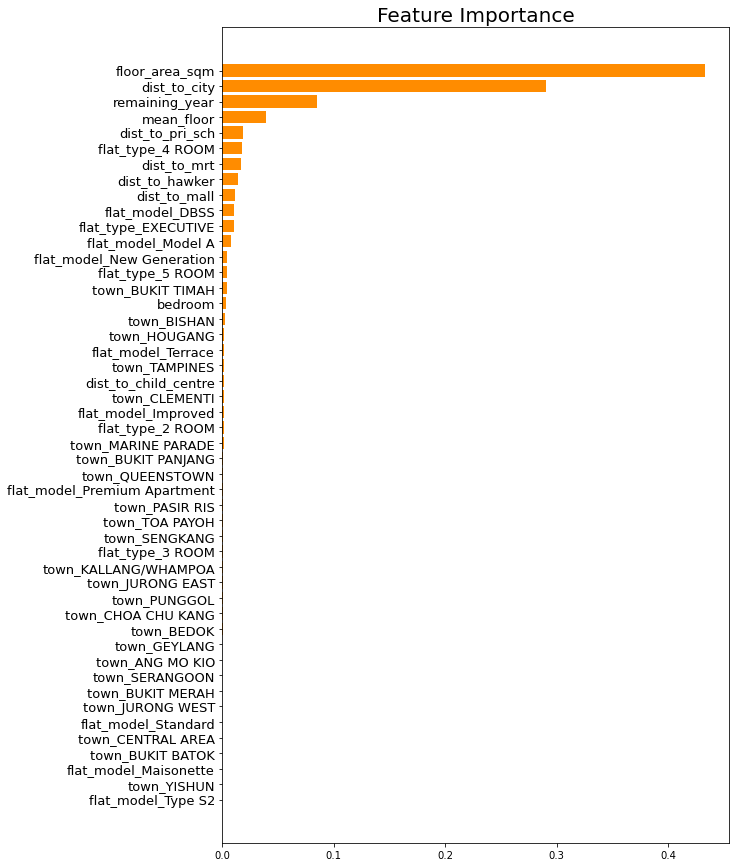

In [45]:
feature_importance = gb_gs.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='darkorange')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx], fontsize = 13)
plt.title('Feature Importance', fontsize = 20);

### Refit model to HDB Data

In [48]:
# instantiate TfidfVectorizer and MultinomialNB pipeline
pipe_gb = Pipeline([('ss', StandardScaler()),
                    ('gb', GradientBoostingRegressor(random_state=42))])

# Define dictionary of hyperparameters
pipe_params_gb = {'gb__alpha': [0.005, 0.01],
                  'gb__learning_rate': [0.2, 0.25],
                  'gb__max_depth': [5, 7],
                  'gb__min_samples_leaf': [3],
                  'gb__n_estimators': [500, 700]
                  }

# Instantiate GridSearchCV.
gs_gb = GridSearchCV(pipe_gb, param_grid=pipe_params_gb, cv=5, verbose=1, scoring='r2', n_jobs=-1)

# fit to X_train_clean1, y_train
gs_gb.fit(X, y)

# find the best estimator
gs_gb_model = gs_gb.best_estimator_
gs_gb_model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 48.4min finished


Pipeline(steps=[('ss', StandardScaler()),
                ('gb',
                 GradientBoostingRegressor(alpha=0.005, learning_rate=0.2,
                                           max_depth=7, min_samples_leaf=3,
                                           n_estimators=500,
                                           random_state=42))])

In [49]:
print(f'HDB Data R2: {round(gs_gb_model.score(X, y), 4)}')
print(f'CV R2: {round((cross_val_score(gs_gb_model, X, y, cv=5)).mean(), 4)}')
print(f'HDB Data adj_R2: {round((1 - (1 - gs_gb_model.score(X, y)) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))), 4)}')
print(f'CV adj_R2: {round((1 - (1 - (cross_val_score(gs_gb_model, X, y, cv=5)).mean()) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))), 4)}')
print(f'HDB RMSE: {round(np.sqrt(mean_squared_error(y, gs_gb_model.predict(X))), 2)}')
print(f'CV RMSE: {round(-cross_val_score(gs_gb_model, X, y, cv=5, scoring="neg_root_mean_squared_error").mean(), 2)}')

HDB Data R2: 0.9866
CV R2: 0.9686
HDB Data adj_R2: 0.9866
CV adj_R2: 0.9686
HDB RMSE: 17815.11
CV RMSE: 27102.18


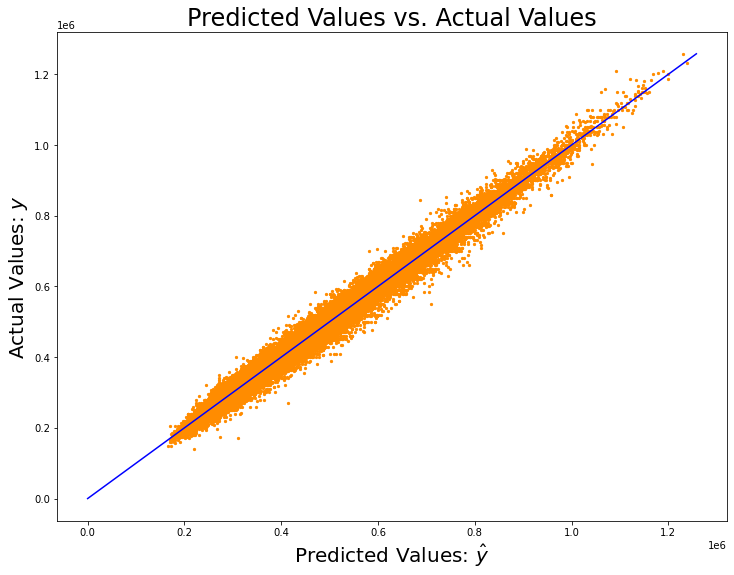

In [50]:
# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(gs_gb_model.predict(X), y, s=5, color='darkorange')

# Plot a line.
plt.plot([0, np.max(y)],
         [0, np.max(y)],
         color = 'blue')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

Majority of the points are fill around the diagonal line, this means that on average our residuals are reasonable small which is a good fit.

### Feature Importances

In [51]:
# Refit best parameters on HDB data
final_model = gs_gb_model.fit(X, y)

In [52]:
# List of feature_importances_ by Gradient Boosting Regression
feat_imp = pd.DataFrame(final_model.steps[1][1].feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feat_imp.head(10)

,Importance
floor_area_sqm,0.442781
dist_to_city,0.284070
remaining_year,0.085102
mean_floor,0.038683
dist_to_pri_sch,0.020156
dist_to_mrt,0.017810
dist_to_hawker,0.013576
dist_to_mall,0.012108
flat_type_4 ROOM,0.012104
flat_model_DBSS,0.009916


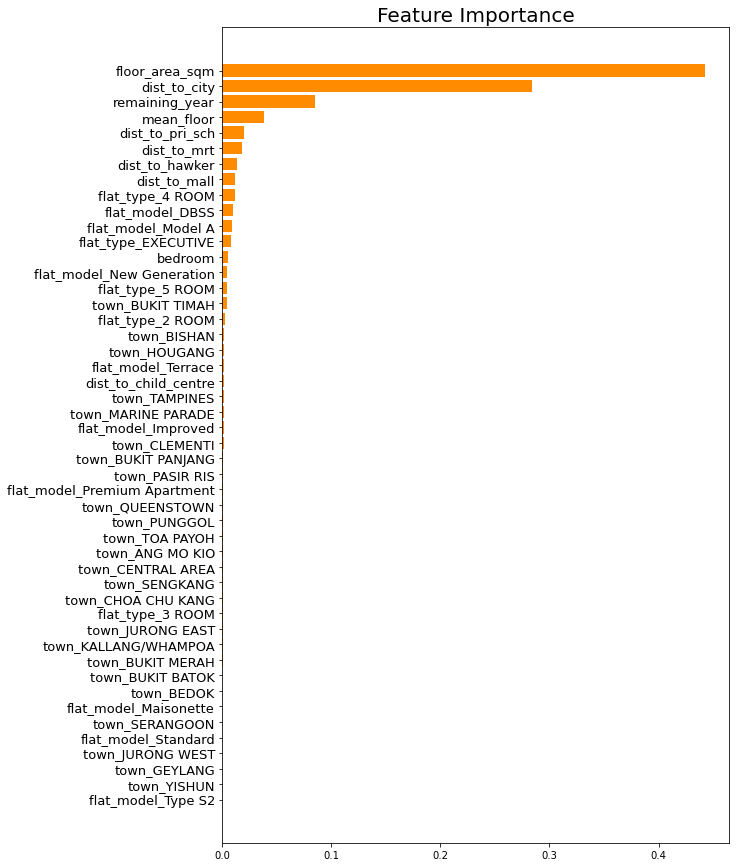

In [53]:
feature_importance = gs_gb_model.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='darkorange')
plt.yticks(pos, np.array(X.columns)[sorted_idx], fontsize = 13)
plt.title('Feature Importance', fontsize = 20);

In [54]:
# save the model to disk
# pkl_filename = 'finalized_model.pkl'
# pickle.dump(gs_gb_model, open(pkl_filename, 'wb'))

In [60]:
# load the model from disk
pickle_model = pickle.load(open('finalized_model.pkl', 'rb'))

In [56]:
hdb = pd.read_csv('dataset/hdb_17_final_features.csv')

In [57]:
X = hdb.drop(columns=['resale_price'])
y = hdb['resale_price']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
print(f'HDB Data R2: {round(pickle_model.score(X, y), 4)}')

HDB Data R2: 0.9824


## Conclusion

As you can see from the work above, I have undertaken comprehensive analysis.

In summary, I assessed the EDA, undertook feature engineering/selection and ran regression machine learning models to select the most predictive model. As a result, I have successfully created a model that is able to predict the HDB flat `resale_price` in Singapore. The Gradient Boosting Regressor has achieved satisfactory results (RMSE: \\$20,394, R-squared: 98.24\%) for HDB resale price prediction compare to the base model (Linear Regression) results (RMSE: \\$35,954, R-squared: 94.54\% - under section 2.3: Checking for Homoscedasticity). The Gradient Boosting Regressor model is superior to a simple Linear Regression model due to xxxx

The top 5 features that impact the resale price based on the Gradient Boosting Regressor feature importance scores are:
1. floor_area_sqm – it is obvious that the bigger the space, the greater the price of the HDB flat,
2. dist_to_city – the nearer to the city, you will able to access to the better amenities and facilities,
3. remaining_year – the longer the lease, you will able to apply for larger loan from the HDB or banks and the condition of the HDB flat would be relatively better,
4. mean_floor – the higher floor, you will have better view, cooler, less noise, less mosquitoes etc,
5. dist_to_pri_sch – Singapore citizen who live within 1km of the school will be given priority to get into the primary school. Most of the Singaporean families will tend stay near to the top primary school so that their children will able to get into the school.
    
I have also created a user-friendly __web application__ that require the user to select the features of their preferred HDB flat. Then the back-end application will generate the predictive price to provide the real time prediction.

## Benefits of the model

1. The predictive price is presented as a range e.g., the predicted price is \\$450,000, the range is between \\$430,000 to \\$470,000,
2. Multiple features to improve price prediction,
3. User-friendly web application,
4. Can be used equally by buyer, seller, property agents or agencies and others.
    
## Limitations of the model

1. The model is only able to predict the price for the nominated features, but the user is not able to enter the target price and then receive available HDB resale flats for that price and the associated features,
2. This model is not applicable for other property price prediction because of the different features,
3. Additional datasets not included may have been useful eg. GDP, population density of the HDB estates.
    
## Future Work

Although my model has generated a reasonable low RMSE and high R-squared value (compare to baseline model), it should be noted that the real HDB flat resale price is much more complex and the list of the features, understandably is not an exhaustive list.

There are many other factors should be taken into consideration such as overall flat conditions, overall Singapore economic conditions, government housing regulation or prospective future development at different town. In addition, it would be better if we have the information of the HDB flat original value when it was first sold.

People's individual motivations will impact the price they are prepared to pay e.g., if I work in the West, I am likely to be prepared to pay more for HDB flat in the West than someone working in the East as we both factor in convenience in regards to travel in our price expectation. For someone working and living in the west, the travel time from home to CBD may not be of high priority, since they will spend most of their time within their neighbouirhood.

Likewise, other social factor influences the price e.g., a neighbourhood may be undergoing upgrading new shopping mall, facilities etc and making it a "cooler" place to live. None of the datasets included capture such an issue.

## Model Improvement

Some specific elements to add to improve the predictivity of the model include:
1. Additional features such as flat condition rating, GDP and population density of the HDB estates,
2. Scrape more data from the different resources such as PropertyGuru or 99.co website,
3. Retrain the model weight as and when new data added,
4. Train a new model if new feature/s added,
5. Tuning the hyperparameters of the machine learning model to discover the parameters of the model that result in the most skillful predictions.

## Web Application Improvement

Potential improvement for the web application includes:
1. Reduce the number of user inputs by having automatic default selection e.g., when 4-Room flat is selected, the number of bedrooms and bathrooms will be filled automatically,
2. Map driven selection,
3. Visual display and details of the facilities and amenities around the area.

Overall, the model is fit for purpose. It predicts price with a reasonable RMSE, is easy to use and processes the result quickly. More data and features would improve the model but I am pleased to recommend this model to the future HDB purchasers - like myself.